In [2]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 64.8 kB/s eta 0:00:0000:0100:18
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 313.1 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 154.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import datetime
import random
 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
#from imblearn.over_sampling import SMOTE
import optuna
 
import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 def random_seed(seed_value): 
    np.random.seed(seed_value)
 #cpu vars
# cpu  vars
    random.seed(seed_value)


In [3]:
random_seed(2021)

In [4]:
#  def random_seed(seed_value, use_cuda): 
#     np.random.seed(seed_value)
#  #cpu vars
#     torch.manual_seed(seed_value) 
# # cpu  vars
#     random.seed(seed_value)
#  # Python 
#     if use_cuda: 
#         torch.cuda.manual_seed(seed_value) 
#         torch.cuda.manual_seed_all(seed_value) 
# # gpu vars
#         torch.backends.cudnn.deterministic = True 
#  #needed
#         torch.backends.cudnn.benchmark = False 
# #Remember to use num_workers=0 when creating the DataBunch.

In [5]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

### Checking for features that correlate with the target variable

In [7]:
# train.corr()['FraudResult'].sort_values().plot(kind='bar', figsize=(7, 6))

## Target Distribution

In [8]:
train['FraudResult'].value_counts()

FraudResult
0    95469
1      193
Name: count, dtype: int64

In [9]:
target = train.FraudResult
train = train.drop("FraudResult", axis = 1)

### Preprocessing/Feature Engineering

In [10]:
train.shape, test.shape

((95662, 15), (45019, 15))

In [11]:
data = pd.concat([train, test], ignore_index=True)

In [12]:
# data=train.append(test)

In [13]:
data.isnull().sum()

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
dtype: int64

In [99]:
data['TransactionId'].value_counts()

TransactionId
TransactionId_45927     1
TransactionId_76871     1
TransactionId_73770     1
TransactionId_26203     1
TransactionId_380       1
                       ..
TransactionId_104687    1
TransactionId_94963     1
TransactionId_33857     1
TransactionId_51800     1
TransactionId_130161    1
Name: count, Length: 140681, dtype: int64

In [17]:
data['BatchId'].value_counts()

BatchId
BatchId_67019     28
BatchId_51870     16
BatchId_113893    14
BatchId_127204    12
BatchId_116835    10
                  ..
BatchId_115280     1
BatchId_114758     1
BatchId_88689      1
BatchId_53602      1
BatchId_62059      1
Name: count, Length: 139493, dtype: int64

In [18]:
data['PricingStrategy'].value_counts()

PricingStrategy
2    117426
4     20043
1      2559
0       653
Name: count, dtype: int64

In [19]:
data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy'],
      dtype='object')

In [20]:
data['CurrencyCode'].value_counts()

CurrencyCode
UGX    140681
Name: count, dtype: int64

In [21]:
data['CountryCode'].value_counts()

CountryCode
256    140681
Name: count, dtype: int64

In [22]:
data['ChannelId'].value_counts()

ChannelId
ChannelId_3    95025
ChannelId_2    43339
ChannelId_5     1650
ChannelId_1      640
ChannelId_4       27
Name: count, dtype: int64

In [23]:
data['ProductCategory'].value_counts()

ProductCategory
financial_services    67105
airtime               65950
utility_bill           2660
data_bundles           2527
tv                     1738
movies                  253
ticket                  232
retail                  184
transport                30
other                     2
Name: count, dtype: int64

In [24]:
data['ProductId'].value_counts()

ProductId
ProductId_6     47821
ProductId_3     34654
ProductId_10    23866
ProductId_15    17971
ProductId_1      4097
ProductId_4      3278
ProductId_11     2244
ProductId_21     2078
ProductId_19     1299
ProductId_14     1262
ProductId_13      401
ProductId_2       277
ProductId_8       271
ProductId_24      253
ProductId_20      232
ProductId_26      184
ProductId_22      181
ProductId_7       128
ProductId_16       45
ProductId_27       40
ProductId_25       31
ProductId_5        30
ProductId_9        20
ProductId_18        7
ProductId_17        6
ProductId_23        3
ProductId_12        2
Name: count, dtype: int64

In [25]:
data['BatchId'].value_counts()

BatchId
BatchId_67019     28
BatchId_51870     16
BatchId_113893    14
BatchId_127204    12
BatchId_116835    10
                  ..
BatchId_115280     1
BatchId_114758     1
BatchId_88689      1
BatchId_53602      1
BatchId_62059      1
Name: count, Length: 139493, dtype: int64

In [26]:
data['SubscriptionId'].value_counts()

SubscriptionId
SubscriptionId_3829    47833
SubscriptionId_4429     4592
SubscriptionId_3654     1961
SubscriptionId_4346     1315
SubscriptionId_3087     1188
                       ...  
SubscriptionId_2767        1
SubscriptionId_401         1
SubscriptionId_3191        1
SubscriptionId_3019        1
SubscriptionId_389         1
Name: count, Length: 4836, dtype: int64

In [27]:
data['Value'].value_counts()

Value
1000      27193
5000      15190
10000     12991
50        12493
500        8144
          ...  
48800         1
275000        1
755           1
28626         1
10750         1
Name: count, Length: 1880, dtype: int64

In [28]:
data['Amount'].value_counts()

Amount
 1000.0     24343
 10000.0    13401
-50.0       12476
-5000.0      8167
 2000.0      7555
            ...  
 1094.0         1
 9975.0         1
 34900.0        1
 70.0           1
 13272.0        1
Name: count, Length: 2099, dtype: int64

In [15]:
data['TransactionStartTime'].value_counts()

TransactionStartTime
2018-12-24T16:30:13Z    17
2018-11-15T07:03:26Z     9
2018-12-24T16:30:12Z     6
2018-12-07T13:09:44Z     6
2018-11-15T07:03:27Z     5
                        ..
2018-12-30T16:49:32Z     1
2018-12-30T16:50:30Z     1
2018-12-30T16:51:23Z     1
2018-12-30T16:53:57Z     1
2018-12-30T16:41:54Z     1
Name: count, Length: 138574, dtype: int64

In [15]:
# train_data = train_data[selected_features+["AccountId"]+["FraudResult"]]

In [16]:
# date_col = ['TransactionStartTime']

In [61]:
# # Extract date features
# def extract_date_info(df,cols,):
#     for feat in cols:
#         df[feat +'_year'] = df[feat].dt.quarter
#         df[feat +'_day'] = df[feat].dt.day
#         df[feat +'_month'] = df[feat].dt.month
#         df[feat +'_quarter'] = df[feat].dt.quarter
#         df[feat +'_weekday'] = df[feat].dt.weekday
#         df[feat +'_week'] = df[feat].dt.isocalendar().week
#     df.drop(columns=date_col,axis=1,inplace=True)


# extract_date_info(data_,date_col)

In [106]:
# train=data_.iloc[:95662,]
# test= data_.iloc[95662:,]
# y = target

In [107]:
# train.shape, test.shape

((95662, 14), (45019, 14))

In [108]:
# rf_model.fit(train, y)

In [14]:
# FEATURE ENGINEERING
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'], errors='coerce')

# Drop redundant or ID-only columns
drop_cols = ['CurrencyCode', 'CountryCode', 'SubscriptionId','TransactionId', 'BatchId']# ['CurrencyCode', 'CountryCode', 'SubscriptionId','TransactionId', 'BatchId', 'Value', 'CustomerId', 'ChannelId'] #, 'SubscriptionId', 'TransactionStartTime', 'Value',  'ChannelId',
data = data.drop(columns=drop_cols)

In [15]:
# # df['hour'] = df['TransactionStartTime'].dt.hour
# # df['dayofweek'] = df['TransactionStartTime'].dt.dayofweek
# # df['month'] = df['TransactionStartTime'].dt.month

# # Drop redundant or ID-only columns
# drop_cols = ['CurrencyCode', 'CountryCode', 'SubscriptionId','TransactionId', 'BatchId'] #, 'SubscriptionId', 'TransactionStartTime', 'Value'
# data = data.drop(columns=drop_cols)

In [16]:
data.columns

Index(['AccountId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'Amount', 'Value', 'TransactionStartTime',
       'PricingStrategy'],
      dtype='object')

In [17]:
# # Optionally add transaction frequency by AccountId
# data['AccountTransactionCount'] = data.groupby('AccountId')['Amount'].transform('count')

In [18]:
# One hot encoding of all categorical feature

# batchid_dummies = pd.get_dummies(data.BatchId)
# data = pd.concat([data,batchid_dummies], axis=1)
# data = data.drop("BatchId", axis=1)

AccountId_dummies = pd.get_dummies(data.AccountId)
data = pd.concat([data,AccountId_dummies], axis=1)
data = data.drop("AccountId", axis=1)
  
# SubscriptionId_dummies = pd.get_dummies(data.SubscriptionId)
# data = pd.concat([data,SubscriptionId_dummies], axis=1)
# data = data.drop("SubscriptionId", axis=1)
  
CustomerId_dummies = pd.get_dummies(data.CustomerId)
data = pd.concat([data,CustomerId_dummies], axis=1)
data = data.drop("CustomerId", axis=1)
  
ProviderId_dummies = pd.get_dummies(data.ProviderId)
data = pd.concat([data,ProviderId_dummies], axis=1)
data = data.drop("ProviderId", axis=1)
  
ProductId_dummies = pd.get_dummies(data.ProductId)
data = pd.concat([data,ProductId_dummies], axis=1)
data = data.drop("ProductId", axis=1)
  
ProductCategory_dummies = pd.get_dummies(data.ProductCategory)
data = pd.concat([data,ProductCategory_dummies], axis=1)
data = data.drop("ProductCategory", axis=1)

ChannelId_dummies = pd.get_dummies(data.ChannelId)
data = pd.concat([data,ChannelId_dummies], axis=1)
data = data.drop("ChannelId", axis=1)
  
#del data['TransactionId']

In [19]:
# drop_cols = ['AccountId'] #, 'SubscriptionId', 'TransactionStartTime', 'Value'
# data = data.drop(columns=drop_cols)

In [20]:
data.shape # without batchID

(140681, 12372)

In [75]:
data.shape

(140681, 4888)

In [76]:
data.shape

(140681, 4888)

In [21]:
date_col = ['TransactionStartTime']

In [22]:
# Extract date features
def extract_date_info(df,cols,):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.quarter
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
        df[feat +'_weekday'] = df[feat].dt.weekday
        df[feat +'_week'] = df[feat].dt.isocalendar().week
    df.drop(columns=date_col,axis=1,inplace=True)


extract_date_info(data,date_col)

In [23]:
data.head(2)

,Amount,Value,PricingStrategy,AccountId_1,AccountId_10,AccountId_100,AccountId_1000,AccountId_1001,AccountId_1002,AccountId_1003,...,ChannelId_2,ChannelId_3,ChannelId_4,ChannelId_5,TransactionStartTime_year,TransactionStartTime_day,TransactionStartTime_month,TransactionStartTime_quarter,TransactionStartTime_weekday,TransactionStartTime_week
0,1000.0,1000,2,False,False,False,False,False,False,False,...,False,True,False,False,4,15,11,4,3,46
1,-20.0,20,2,False,False,False,False,False,False,False,...,True,False,False,False,4,15,11,4,3,46


In [24]:
# rename duplicated columns if present (to prevent errors after one hot encoding)
cols=pd.Series(data.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
data.columns=cols

One hot encoding increased data dimension to over 500 features, Some irrelevant features had to be droped after observing feature importance for previous models. Most irrelvant features were from `LGA_Name`..
- This could have been done in a less error prone and more efficient way, but due to time constraint, we just copied straight from `data.columns`

### Modelling

In [25]:
train=data.iloc[:95662,]
test= data.iloc[95662:,]
y = target

In [26]:
from lightgbm import LGBMClassifier

In [27]:
train.shape, test.shape

((95662, 12377), (45019, 12377))

In [84]:
# train.shape, test.shape

In [59]:


# OPTUNA OBJECTIVE FUNCTION
def objective(trial):
    # Hyperparameters for LightGBM
    params = {
        "objective": "binary",
        "metric": "f1",
        "verbosity": -1,
        "boosting_type": "gbdt",
        #"class_weight": "balanced",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "scale_pos_weights": trial.suggest_int("scale_pos_weights", 5, 15)
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0),
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in skf.split(train, y):
        X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Balance with SMOTE (optional alternative: class_weight)
        #sm = SMOTE(random_state=42)
        #X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        f1 = f1_score(y_valid, y_pred)
        f1_scores.append(f1)

    return np.mean(f1_scores)




In [104]:

# # RUN OPTUNA without AccountID
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

In [105]:

# # RUN OPTUNA
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

In [36]:

# # RUN OPTUNA
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

[I 2025-04-12 14:11:28,173] A new study created in memory with name: no-name-095b987f-461b-491b-8de8-2b29bb3e5da6
[I 2025-04-12 14:13:06,007] Trial 0 finished with value: 0.8480679927681027 and parameters: {'learning_rate': 0.2128109039513035, 'num_leaves': 41, 'max_depth': 8, 'scale_pos_weights': 6, 'min_child_samples': 64, 'subsample': 0.6348016460568944, 'colsample_bytree': 0.9904535287526395, 'reg_alpha': 6.992225111178895, 'reg_lambda': 6.543400506529025}. Best is trial 0 with value: 0.8480679927681027.
[I 2025-04-12 14:14:39,854] Trial 1 finished with value: 0.8604642812329149 and parameters: {'learning_rate': 0.11427434376905293, 'num_leaves': 45, 'max_depth': 9, 'scale_pos_weights': 8, 'min_child_samples': 82, 'subsample': 0.9881784810737428, 'colsample_bytree': 0.9376548843214776, 'reg_alpha': 3.4187424756833655, 'reg_lambda': 7.038530697266246}. Best is trial 1 with value: 0.8604642812329149.
[I 2025-04-12 14:16:13,882] Trial 2 finished with value: 0.899282538884181 and param

KeyboardInterrupt: 

In [59]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold
# import optuna
# import numpy as np

# def objective(trial):
#     # Hyperparameters for Random Forest
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 5, 30),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
#         "class_weight": "balanced",  # Handle imbalance
#         "random_state": 42,
#         "n_jobs": -1,
#     }

#     skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
#     f1_scores = []

#     for train_idx, valid_idx in skf.split(train, y):
#         X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#         # Optional: Use SMOTE instead of class_weight (uncomment if needed)
#         # from imblearn.over_sampling import SMOTE
#         # sm = SMOTE(random_state=42)
#         # X_train, y_train = sm.fit_resample(X_train, y_train)

#         model = RandomForestClassifier(**params)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_valid)

#         f1 = f1_score(y_valid, y_pred)
#         f1_scores.append(f1)

#     return np.mean(f1_scores)


In [60]:

# # RUN OPTUNA
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

[I 2025-04-12 20:03:06,608] A new study created in memory with name: no-name-7d9b9300-54af-4676-a73e-7566ff6d922d
[I 2025-04-12 20:03:33,281] Trial 0 finished with value: 0.037539245115344136 and parameters: {'n_estimators': 479, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.037539245115344136.
[I 2025-04-12 20:10:22,122] Trial 1 finished with value: 0.8614551252176114 and parameters: {'n_estimators': 426, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.8614551252176114.
[I 2025-04-12 20:10:46,248] Trial 2 finished with value: 0.04496448633770278 and parameters: {'n_estimators': 355, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8614551252176114.
[I 2025-04-12 20:11:06,393] Trial 3 finished with value: 0.03551209962534621 and parameters: {'n_estimators': 270, 'max_depth': 1

KeyboardInterrupt: 

In [61]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'learning_rate': 0.29414755681441, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 52, 'subsample': 0.6461882121263627, 'colsample_bytree': 0.7166542109176228, 'reg_alpha': 0.007648346351238698, 'reg_lambda': 0.9928717921584541}


- We performed 8 fold cross validation on the training data, predicting on the test set after each iteration.
- The mode(most occuring value) of all 8 predictions was then used to make final submission. More like Voting
- The most important hyperparameter used here is `scale_pos_weight`,Since we are dealing with an imbalanced dataset, by manually tuning this hyperparameter the model tries to balance the ratio of both positive and negative classes

In [ ]:
# best_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 5, 30),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
#         "class_weight": "balanced",  # Handle imbalance
#         "random_state": 42,
#         "n_jobs": -1,
#     }

In [85]:
# #without accountID scale 15
# best_params = {
#         "objective": "binary",
#         "metric": "f1",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#     'learning_rate': 0.29414755681441, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 52, 'subsample': 0.6461882121263627, 'colsample_bytree': 0.7166542109176228, 'reg_alpha': 0.007648346351238698, 'reg_lambda': 0.9928717921584541,
#      'scale_pos_weights': 3#6
#     }



In [47]:
# #without accountID scale 15
# best_params = {
#         "objective": "binary",
#         "metric": "f1",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#     'learning_rate': 0.2640747807023049, 'num_leaves': 32, 'max_depth': 11, 'scale_pos_weights': 7, 'min_child_samples': 31, 'subsample': 0.9468553253674176, 'colsample_bytree': 0.6460990597149006, 'reg_alpha': 0.0007576361550403407, 'reg_lambda': 0.004779015671386833
#     }



In [89]:
# #without amount
# best_params = {
#         "objective": "binary",
#         "metric": "f1",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#     'learning_rate': 0.172351525757494, 'num_leaves': 30, 'max_depth': 9, 'scale_pos_weights': 12, 'min_child_samples': 97, 'subsample': 0.9207949161279785, 'colsample_bytree': 0.9884822037594487, 'reg_alpha': 0.45941765039395743, 'reg_lambda': 0.751019177610813
#     }



In [28]:
best_params = {
        "objective": "binary",
        "metric": "f1",
        "verbosity": -1,
        "boosting_type": "gbdt",
    'learning_rate': 0.1295001672428931, 'num_leaves': 17, 'max_depth': 5, 'scale_pos_weights': 11, 'min_child_samples': 14, 'subsample': 0.9049752358213653, 'colsample_bytree': 0.5374480848695044, 'reg_alpha': 0.20035335432305929, 'reg_lambda': 1.091647369417446
    }

In [ ]:
# {'learning_rate': 0.1295001672428931, 'num_leaves': 17, 'max_depth': 5, 'scale_pos_weights': 11, 'min_child_samples': 14, 'subsample': 0.9049752358213653, 'colsample_bytree': 0.5374480848695044, 'reg_alpha': 0.20035335432305929, 'reg_lambda': 1.091647369417446

In [29]:
from sklearn.model_selection import StratifiedKFold
predictions = []
fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42)
for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    classifier2=LGBMClassifier(**best_params)
    classifier2.fit(X_train, Y_train)
    preds=classifier2.predict(X_test)
    predictions.append(classifier2.predict(test))

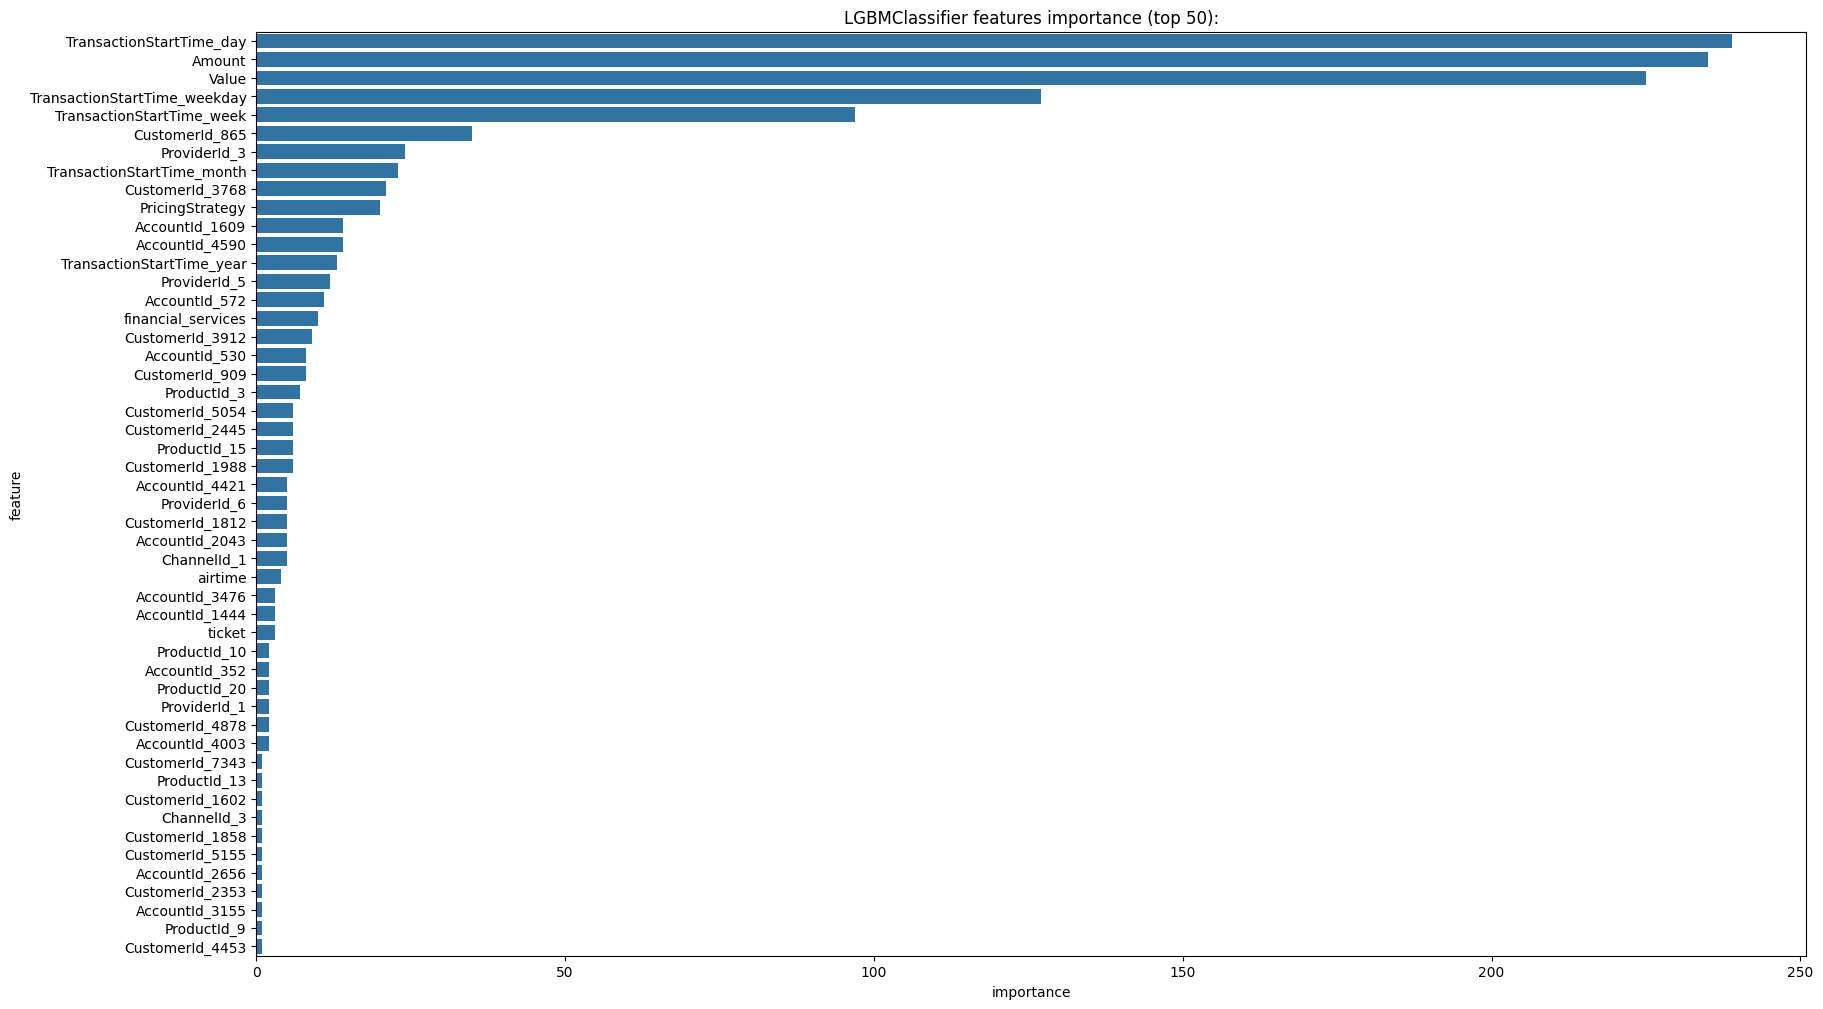

In [38]:
feature_importance_df = pd.DataFrame(classifier2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('LGBMClassifier features importance (top 50):');

In [46]:
data_imp=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50)
data_imp


,importance,feature
12372,239,TransactionStartTime_day
0,235,Amount
1,225,Value
12375,127,TransactionStartTime_weekday
12376,97,TransactionStartTime_week
12174,35,CustomerId_865
12325,24,ProviderId_3
12373,23,TransactionStartTime_month
7920,21,CustomerId_3768
2,20,PricingStrategy


In [47]:
data_imp[data_imp['importance']>1]['feature'].to_list()

['TransactionStartTime_day',
 'Amount',
 'Value',
 'TransactionStartTime_weekday',
 'TransactionStartTime_week',
 'CustomerId_865',
 'ProviderId_3',
 'TransactionStartTime_month',
 'CustomerId_3768',
 'PricingStrategy',
 'AccountId_1609',
 'AccountId_4590',
 'TransactionStartTime_year',
 'ProviderId_5',
 'AccountId_572',
 'financial_services',
 'CustomerId_3912',
 'AccountId_530',
 'CustomerId_909',
 'ProductId_3',
 'CustomerId_5054',
 'CustomerId_2445',
 'ProductId_15',
 'CustomerId_1988',
 'AccountId_4421',
 'ProviderId_6',
 'CustomerId_1812',
 'AccountId_2043',
 'ChannelId_1',
 'airtime',
 'AccountId_3476',
 'AccountId_1444',
 'ticket',
 'ProductId_10',
 'AccountId_352',
 'ProductId_20',
 'ProviderId_1',
 'CustomerId_4878',
 'AccountId_4003']

In [48]:
CustomerId_l = ['CustomerId_865', 'CustomerId_3768', 'CustomerId_3912', 'CustomerId_909', 'CustomerId_5054', 'CustomerId_5054', 'CustomerId_2445', 'CustomerId_1988', 'CustomerId_1812', 'CustomerId_4878']
ProviderId = ['ProviderId_3', 'ProviderId_5', 'ProviderId_6', 'ProviderId_1']
AccountId = ['AccountId_1609', 'AccountId_4590', 'AccountId_572', 'AccountId_530', 'AccountId_4421', 'AccountId_2043', 'AccountId_3476', 'AccountId_1444', 'AccountId_352', 'AccountId_4003']
ProductId = ['ProductId_3', 'ProductId_15', 'ProductId_10', 'ProductId_20']
ProductCategory = ['financial_services', 'airtime', 'ticket']

In [80]:
# id_s = ['TransactionId_24572', 'TransactionId_11374', 'TransactionId_62319', 'TransactionId_54314', 'TransactionId_88480', 'TransactionId_58126', 'TransactionId_96723', 'TransactionId_25972', 'TransactionId_52013', 'TransactionId_66741', 'TransactionId_56324', 'TransactionId_59334', 'TransactionId_39833', 'TransactionId_107721', 'TransactionId_22658' ]
# sub_file[sub_file.TransactionId.isin(id_s)]

,TransactionId,FraudResult
5233,TransactionId_59334,1.0
5237,TransactionId_107721,1.0
5246,TransactionId_22658,1.0
5256,TransactionId_11374,1.0
5257,TransactionId_39833,1.0
5271,TransactionId_88480,1.0
5273,TransactionId_54314,1.0
5276,TransactionId_24572,1.0
5367,TransactionId_62319,1.0
13050,TransactionId_58126,1.0


In [74]:
# sub_file = pd.read_csv('confirm_score_reproducibility_galsen_lgbm.csv')

In [75]:
# id_s = ['TransactionId_50612', 'TransactionId_58126', 'TransactionId_96723', 'TransactionId_120345', 'TransactionId_41874', 'TransactionId_20171', 'TransactionId_35117']
# sub_file[sub_file.TransactionId.isin(id_s)]

,TransactionId,FraudResult
2728,TransactionId_50612,1.0
13050,TransactionId_58126,1.0
13051,TransactionId_96723,1.0
15546,TransactionId_120345,1.0
21752,TransactionId_41874,1.0
21888,TransactionId_20171,1.0
43262,TransactionId_35117,1.0


In [ ]:

# test[test.TransactionId.isin(id_pos_transac)]

In [31]:
predictions = pd.DataFrame(predictions)

In [32]:
predictions.T.head()

,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [33]:
predictions = predictions.mode()

In [34]:
predictions = predictions.T
predictions

,0,1
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN
...,...,...
45014,0.0,NaN
45015,0.0,NaN
45016,0.0,NaN
45017,0.0,NaN


In [36]:
sub = predictions[0]
sub

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
45014    0.0
45015    0.0
45016    0.0
45017    0.0
45018    0.0
Name: 0, Length: 45019, dtype: float64

In [76]:
sub_file.FraudResult = sub

In [89]:
sub_file.to_csv('confirm_score_reproducibility_galsen_lgbm',index=False)

### Rule Based Expert System

In [39]:
id_pos_transac = ['TransactionId_59595',
 'TransactionId_87268',
 'TransactionId_9176',
 'TransactionId_114219',
 'TransactionId_87779',
 'TransactionId_26542']

In [40]:
id_neg_transac = ['TransactionId_112820',
 'TransactionId_123757',
 'TransactionId_70610',
 'TransactionId_84063']

In [133]:
train[train.TransactionId.isin(id_pos_transac)]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy


In [135]:
test

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,0,0,0,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,0,1,1,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,0,0,1,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,0,0,0,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,0,0,1,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45014,TransactionId_116198,BatchId_117348,AccountId_4841,SubscriptionId_3829,CustomerId_5225,UGX,256,0,0,1,ChannelId_3,-5000.0,5000,2019-03-14T23:56:28Z,2
45015,TransactionId_24829,BatchId_53630,AccountId_4803,SubscriptionId_1738,CustomerId_5272,UGX,256,1,0,0,ChannelId_3,10000.0,10000,2019-03-14T23:57:38Z,1
45016,TransactionId_102920,BatchId_112209,AccountId_4817,SubscriptionId_4613,CustomerId_5286,UGX,256,1,0,0,ChannelId_3,10000.0,10000,2019-03-14T23:59:17Z,1
45017,TransactionId_128439,BatchId_58734,AccountId_4841,SubscriptionId_3829,CustomerId_5286,UGX,256,0,0,1,ChannelId_3,-5000.0,5000,2019-03-14T23:59:39Z,2


In [136]:
test[test.TransactionId.isin(id_pos_transac)]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
17633,TransactionId_87268,BatchId_79139,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-23T13:01:54Z,2
17634,TransactionId_59595,BatchId_79139,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-23T13:02:04Z,2
19271,TransactionId_26542,BatchId_73458,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-25T05:35:55Z,2
19273,TransactionId_87779,BatchId_73458,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-25T05:36:18Z,2
19674,TransactionId_114219,BatchId_92056,AccountId_4014,SubscriptionId_4460,CustomerId_4464,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-25T12:19:34Z,2
19677,TransactionId_9176,BatchId_102587,AccountId_4014,SubscriptionId_4460,CustomerId_4464,UGX,256,1,1,1,ChannelId_3,1000000.0,1000000,2019-02-25T12:20:27Z,2


In [134]:
train[train.TransactionId.isin(id_neg_transac)]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy


In [137]:
test[test.TransactionId.isin(id_neg_transac)]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
23533,TransactionId_70610,BatchId_22710,AccountId_382,SubscriptionId_2404,CustomerId_712,UGX,256,1,1,1,ChannelId_3,500000.0,500000,2019-02-28T21:07:11Z,0
24868,TransactionId_112820,BatchId_31076,AccountId_2681,SubscriptionId_4703,CustomerId_3101,UGX,256,1,1,1,ChannelId_3,500000.0,500000,2019-03-01T10:27:57Z,0
24939,TransactionId_123757,BatchId_118289,AccountId_2681,SubscriptionId_4703,CustomerId_3101,UGX,256,0,1,1,ChannelId_3,500000.0,500000,2019-03-01T10:51:49Z,0
39192,TransactionId_84063,BatchId_30242,AccountId_3904,SubscriptionId_2418,CustomerId_4350,UGX,256,0,1,1,ChannelId_3,500000.0,500000,2019-03-09T08:12:19Z,0


In [88]:
# sub_file = ss.copy()
# sub_file.FraudResult = preds
# sub_file.head()

In [89]:
# sub_file['FraudResult'].value_counts()

In [148]:
file = pd.read_csv('confirm_score_reproducibility_galsen_lgbm.csv')
file.head()

,TransactionId,FraudResult
0,TransactionId_50600,0.0
1,TransactionId_95109,0.0
2,TransactionId_47357,0.0
3,TransactionId_28185,0.0
4,TransactionId_22140,0.0


In [149]:
file['FraudResult'].value_counts()

FraudResult
0.0    44953
1.0       66
Name: count, dtype: int64

In [150]:
file[file.TransactionId.isin(id_pos_transac)]

,TransactionId,FraudResult
17633,TransactionId_87268,0.0
17634,TransactionId_59595,0.0
19271,TransactionId_26542,0.0
19273,TransactionId_87779,0.0
19674,TransactionId_114219,0.0
19677,TransactionId_9176,0.0


In [151]:
file[file.TransactionId.isin(id_neg_transac)]


,TransactionId,FraudResult
23533,TransactionId_70610,1.0
24868,TransactionId_112820,1.0
24939,TransactionId_123757,1.0
39192,TransactionId_84063,1.0


In [152]:
file.loc[file.TransactionId.isin(id_neg_transac), 'FraudResult']=0
file.loc[file.TransactionId.isin(id_pos_transac),'FraudResult']=1

In [153]:
file['FraudResult'].value_counts()

FraudResult
0.0    44951
1.0       68
Name: count, dtype: int64

In [154]:
file.to_csv('New_submit_LGBM_manuelset_FIRST_SUB.csv', index = False)


In [52]:
train_ = pd.read_csv('training.csv')

In [60]:
ft = train_[train_.CustomerId.isin(CustomerId_l)]
neg_tr = ft[ft['FraudResult']==0]
neg_tr

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
404,TransactionId_82628,BatchId_4739,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_6,ProductId_11,data_bundles,ChannelId_3,1000.0,1000,2018-11-15T15:03:51Z,2,0
1625,TransactionId_56686,BatchId_113373,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,100000.0,100000,2018-11-16T14:10:09Z,4,0
1698,TransactionId_121855,BatchId_29968,AccountId_4841,SubscriptionId_3829,CustomerId_5054,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-5000.0,5000,2018-11-16T14:58:31Z,2,0
1724,TransactionId_103740,BatchId_93054,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_6,ProductId_11,data_bundles,ChannelId_3,1000.0,1000,2018-11-16T15:19:32Z,2,0
1808,TransactionId_85995,BatchId_102292,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1200.0,1200,2018-11-16T16:35:01Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94991,TransactionId_58767,BatchId_128196,AccountId_4841,SubscriptionId_3829,CustomerId_3912,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-40.0,40,2019-02-12T16:52:06Z,2,0
95008,TransactionId_19534,BatchId_47800,AccountId_3476,SubscriptionId_2958,CustomerId_3912,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-12T16:59:38Z,2,0
95009,TransactionId_23767,BatchId_54378,AccountId_4841,SubscriptionId_3829,CustomerId_3912,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-12T16:59:52Z,2,0
95184,TransactionId_58587,BatchId_58023,AccountId_3476,SubscriptionId_2958,CustomerId_3912,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-12T19:14:52Z,2,0


In [61]:
min(neg_tr['Value'])

4

In [62]:
max(neg_tr['Value'])

2400000

In [68]:
max(train_[(train_['ProductCategory'] == 'financial_services') & (train_['FraudResult'] == 0)]['Value'])

2400000

In [67]:
max(train_[(train_['ProductCategory'] == 'financial_services') & (train_['FraudResult'] == 1)]['Value'])

9880000

In [56]:
ft = train_[train_.CustomerId.isin(CustomerId_l)]
pos_tr = ft[ft['FraudResult']==1]
pos_tr


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
4911,TransactionId_66468,BatchId_89498,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,500000.0,500000,2018-11-21T08:26:49Z,4,1
17310,TransactionId_63729,BatchId_62465,AccountId_4421,SubscriptionId_4038,CustomerId_4878,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,500000.0,500000,2018-12-05T09:15:51Z,0,1
17878,TransactionId_139003,BatchId_52403,AccountId_4421,SubscriptionId_4038,CustomerId_4878,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2018-12-06T06:11:05Z,0,1
17881,TransactionId_70597,BatchId_46576,AccountId_4421,SubscriptionId_4038,CustomerId_4878,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,500000.0,500000,2018-12-06T06:12:17Z,0,1
17883,TransactionId_51655,BatchId_108820,AccountId_4421,SubscriptionId_4038,CustomerId_4878,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2018-12-06T06:13:43Z,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82341,TransactionId_68589,BatchId_125935,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-01T17:29:20Z,0,1
82891,TransactionId_83769,BatchId_40333,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,5000000.0,5000000,2019-02-02T03:14:08Z,2,1
82892,TransactionId_49929,BatchId_134443,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-02T03:14:58Z,2,1
82893,TransactionId_41259,BatchId_29896,AccountId_572,SubscriptionId_2950,CustomerId_909,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,5000000.0,5000000,2019-02-02T03:19:05Z,2,1


In [58]:
min(pos_tr['Value'])

500

In [59]:
max(pos_tr['Value'])

8600000

In [ ]:
post_tr[post_tr['Value']==1]

In [43]:
test_ = pd.read_csv('test.csv')

In [45]:
# test_[test_.TransactionId.isin(id_pos_transac)]


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
17633,TransactionId_87268,BatchId_79139,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-23T13:01:54Z,2
17634,TransactionId_59595,BatchId_79139,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-23T13:02:04Z,2
19271,TransactionId_26542,BatchId_73458,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-25T05:35:55Z,2
19273,TransactionId_87779,BatchId_73458,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-25T05:36:18Z,2
19674,TransactionId_114219,BatchId_92056,AccountId_4014,SubscriptionId_4460,CustomerId_4464,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-25T12:19:34Z,2
19677,TransactionId_9176,BatchId_102587,AccountId_4014,SubscriptionId_4460,CustomerId_4464,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-25T12:20:27Z,2


In [72]:
# test_[test_['Value']>2500000]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
2728,TransactionId_50612,BatchId_2518,AccountId_3501,SubscriptionId_3741,CustomerId_3938,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,9000000.0,9000000,2019-02-14T16:21:04Z,2
13050,TransactionId_58126,BatchId_129429,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-21T13:30:59Z,2
13051,TransactionId_96723,BatchId_129429,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-21T13:31:15Z,2
15546,TransactionId_120345,BatchId_17376,AccountId_4725,SubscriptionId_3244,CustomerId_5193,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,9500000.0,9500000,2019-02-22T13:35:52Z,4
21752,TransactionId_41874,BatchId_20535,AccountId_3341,SubscriptionId_1891,CustomerId_3772,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,5000000.0,5000000,2019-02-27T08:34:30Z,2
21888,TransactionId_20171,BatchId_74361,AccountId_2817,SubscriptionId_4785,CustomerId_3239,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,3000000.0,3000000,2019-02-27T11:24:46Z,2
43262,TransactionId_35117,BatchId_96992,AccountId_4370,SubscriptionId_4537,CustomerId_4827,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,7871273.0,7871273,2019-03-13T14:28:16Z,0


In [77]:
# Group by the specified columns and filter groups with more than one occurrence
columns_to_group = ['AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory']
duplicates = test_[test_.duplicated(subset=columns_to_group, keep=False)]

# Sort the result by AccountId
sorted_duplicates = duplicates.sort_values(by='AccountId')
sorted_duplicates

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
7897,TransactionId_106022,BatchId_125652,AccountId_10,SubscriptionId_4346,CustomerId_2441,UGX,256,ProviderId_4,ProductId_3,airtime,ChannelId_5,-1000.0,1000,2019-02-17T05:58:42Z,4
19711,TransactionId_110677,BatchId_14960,AccountId_10,SubscriptionId_4346,CustomerId_3912,UGX,256,ProviderId_4,ProductId_11,data_bundles,ChannelId_5,-1000.0,1000,2019-02-25T12:41:43Z,4
29679,TransactionId_62621,BatchId_79438,AccountId_10,SubscriptionId_4346,CustomerId_4747,UGX,256,ProviderId_4,ProductId_10,airtime,ChannelId_5,-2000.0,2000,2019-03-04T09:58:46Z,4
29678,TransactionId_53215,BatchId_14898,AccountId_10,SubscriptionId_4346,CustomerId_4747,UGX,256,ProviderId_4,ProductId_10,airtime,ChannelId_5,-2000.0,2000,2019-03-04T09:55:38Z,4
19712,TransactionId_138967,BatchId_14960,AccountId_10,SubscriptionId_4346,CustomerId_3912,UGX,256,ProviderId_4,ProductId_11,data_bundles,ChannelId_5,-1000.0,1000,2019-02-25T12:42:18Z,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24424,TransactionId_118041,BatchId_51922,AccountId_996,SubscriptionId_3958,CustomerId_1346,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,5000.0,5000,2019-03-01T08:28:20Z,2
26484,TransactionId_98337,BatchId_28405,AccountId_997,SubscriptionId_1771,CustomerId_1348,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,5000.0,5000,2019-03-01T16:33:11Z,2
26471,TransactionId_39951,BatchId_17512,AccountId_997,SubscriptionId_1771,CustomerId_1348,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,10000.0,10000,2019-03-01T16:31:38Z,2
20423,TransactionId_41980,BatchId_81677,AccountId_999,SubscriptionId_1589,CustomerId_1350,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,1000.0,1000,2019-02-26T05:13:43Z,2


In [81]:
sorted_duplicates[sorted_duplicates['Value']>500000]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
21719,TransactionId_128913,BatchId_17151,AccountId_158,SubscriptionId_3673,CustomerId_481,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,800000.0,800000,2019-02-27T08:11:02Z,2
5276,TransactionId_24572,BatchId_84992,AccountId_191,SubscriptionId_897,CustomerId_514,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-15T14:55:04Z,2
5256,TransactionId_11374,BatchId_87067,AccountId_191,SubscriptionId_897,CustomerId_514,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-15T14:40:43Z,2
5367,TransactionId_62319,BatchId_78133,AccountId_191,SubscriptionId_897,CustomerId_514,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-15T15:32:58Z,2
5273,TransactionId_54314,BatchId_1770,AccountId_191,SubscriptionId_897,CustomerId_514,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-15T14:53:55Z,2
5271,TransactionId_88480,BatchId_1770,AccountId_191,SubscriptionId_897,CustomerId_514,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-15T14:50:04Z,2
23053,TransactionId_29526,BatchId_65413,AccountId_2538,SubscriptionId_4365,CustomerId_2954,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-28T12:36:36Z,2
43896,TransactionId_73567,BatchId_14773,AccountId_2656,SubscriptionId_2912,CustomerId_3075,UGX,256,ProviderId_5,ProductId_13,utility_bill,ChannelId_3,614850.0,645296,2019-03-14T07:44:06Z,2
43899,TransactionId_107582,BatchId_67576,AccountId_2656,SubscriptionId_2912,CustomerId_3075,UGX,256,ProviderId_5,ProductId_13,utility_bill,ChannelId_3,614850.0,645296,2019-03-14T07:47:32Z,2
12840,TransactionId_53904,BatchId_25123,AccountId_306,SubscriptionId_1121,CustomerId_634,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,1000000.0,1000000,2019-02-21T09:54:25Z,2


In [86]:
ft_ids = test_[(test_['AccountId'] == 'AccountId_306') & (test_['SubscriptionId'] == 'SubscriptionId_1121') & (test_['CustomerId'] == 'CustomerId_634')& (test_['Value'] > 500000)]['TransactionId'].to_list()
sub_file[sub_file.TransactionId.isin(ft_ids)]

,TransactionId,FraudResult
12839,TransactionId_10183,0.0
12840,TransactionId_53904,0.0
12842,TransactionId_112983,0.0
12843,TransactionId_132243,0.0
13050,TransactionId_58126,1.0
13051,TransactionId_96723,1.0
17626,TransactionId_66741,1.0
17627,TransactionId_56324,1.0
17631,TransactionId_52013,1.0
17632,TransactionId_25972,1.0


In [87]:
ft_ids = test_[(test_['AccountId'] == 'AccountId_4014') & (test_['SubscriptionId'] == 'SubscriptionId_4460') & (test_['CustomerId'] == 'CustomerId_4464')& (test_['Value'] > 500000)]['TransactionId'].to_list()
sub_file[sub_file.TransactionId.isin(ft_ids)]

,TransactionId,FraudResult
324,TransactionId_59114,1.0
460,TransactionId_116948,1.0
5233,TransactionId_59334,1.0
5237,TransactionId_107721,1.0
5246,TransactionId_22658,1.0
5257,TransactionId_39833,1.0
5258,TransactionId_103156,0.0
5268,TransactionId_59289,0.0
19674,TransactionId_114219,0.0
19677,TransactionId_9176,0.0


In [ ]:
TransactionId_103156, TransactionId_59334, TransactionId_116948, TransactionId_59289, TransactionId_39833, TransactionId_107721, TransactionId_22658, should all be 1 because done on the same day (2019-02-15), same product, same provider, ...

In [ ]:
TransactionId_133930, TransactionId_13904, TransactionId_114219, TransactionId_9176, should be 1 because done on the same day (2019-02-25), same some product, same provider, same account,...

In [ ]:
TransactionId_59289, TransactionId_39833, TransactionId_107721, TransactionId_22658, 

In [ ]:
TransactionId_103156, TransactionId_59289, TransactionId_114219, TransactionId_9176, TransactionId_133930, TransactionId_13904 -> trainsform to 1

In [ ]:
TransactionId_59114 -> transform to 0

In [90]:
id_pos_transac = ['TransactionId_103156', 'TransactionId_59289', 'TransactionId_114219', 'TransactionId_9176', 'TransactionId_133930', 'TransactionId_13904']

In [99]:
file = pd.read_csv('New_submit_LGBM_manuelset_FIRST_SUB.csv')

In [100]:
file

,TransactionId,FraudResult
0,TransactionId_50600,0.0
1,TransactionId_95109,0.0
2,TransactionId_47357,0.0
3,TransactionId_28185,0.0
4,TransactionId_22140,0.0
...,...,...
45014,TransactionId_116198,0.0
45015,TransactionId_24829,0.0
45016,TransactionId_102920,0.0
45017,TransactionId_128439,0.0


In [101]:
file.loc[file.TransactionId.isin(id_pos_transac),'FraudResult']=1

In [102]:
file

,TransactionId,FraudResult
0,TransactionId_50600,0.0
1,TransactionId_95109,0.0
2,TransactionId_47357,0.0
3,TransactionId_28185,0.0
4,TransactionId_22140,0.0
...,...,...
45014,TransactionId_116198,0.0
45015,TransactionId_24829,0.0
45016,TransactionId_102920,0.0
45017,TransactionId_128439,0.0


In [36]:
# file.loc[file.TransactionId.isin(id_neg_transac), 'FraudResult']=0


In [103]:
file.to_csv('New_submit_LGBM_manuelset_FIRST_SUB_rule_based_2.csv', index = False)